In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

In [2]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [3]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")
data['Source'] = 'Original'

In [4]:
X = data[features_num]
y = data[[y_column, 'Source', 'Xray', 'Opt_spec', 'IRAGN', 'Donley']]

In [5]:
le = LabelEncoder()
labels = np.unique(y["Classification"].astype(str))
y["Classification"] = le.fit_transform(y["Classification"])

/var/lib/condor/execute/dir_9432/ipykernel_9558/2943677748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Classification"] = le.fit_transform(y["Classification"])


## BH data

In [6]:
Best_Heckman_data = pd.read_csv("../../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better_fixed_fluxes.csv")
Best_Heckman_data['Source'] = 'BH'

In [7]:
# Only selecting data with a classification
Best_Heckman_data = Best_Heckman_data[Best_Heckman_data['Classification'] != 'Radio-loud AGN'] 

In [8]:
Best_Heckman_X = Best_Heckman_data[[c for c in Best_Heckman_data.columns if c != 'Classification']]
Best_Heckman_y = Best_Heckman_data[['Classification', 'Source']]

In [9]:
Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])

/var/lib/condor/execute/dir_9432/ipykernel_9558/4234724966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])


In [10]:
y = pd.concat([y, Best_Heckman_y]).reset_index(drop=True)

In [11]:
Best_Heckman_X = Best_Heckman_X[['Z_BEST', 'u_flux_corr',
       'g_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'Ks_flux_corr', 'Peak_flux', 'Total_flux']]

# Adding nans to missing columns
Best_Heckman_X[['NUV_flux_corr', 'Bw_flux_corr', 'y_flux_corr', 'K_flux_corr', 
                'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
                'F_SPIRE_500', 'nb921_hsc_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr']] = np.nan

In [12]:
X = pd.concat([X, Best_Heckman_X]).reset_index(drop=True)

### MIGHTEE data

In [13]:
mightee_data = pd.read_csv("../../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")
mightee_data['Source'] = 'MIGHTEE'

In [14]:
# Dropping nan classifications
mightee_data = mightee_data[mightee_data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(mightee_data))

Amount of rows: 4370


In [15]:
mightee_X = mightee_data[[c for c in mightee_data.columns if c != 'Classification']]
mightee_y = mightee_data[['Classification', 'Source', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]

In [16]:
mightee_y['Classification'] = le.transform(mightee_y['Classification'])
y = pd.concat([y, mightee_y]).reset_index(drop=True)

/var/lib/condor/execute/dir_9432/ipykernel_9558/4111256676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mightee_y['Classification'] = le.transform(mightee_y['Classification'])


In [17]:
mightee_X = mightee_X[['Z_BEST', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160',
       'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500', 'Ks_flux_corr',
       'H_flux_corr', 'J_flux_corr', 'i_flux_corr', 'r_flux_corr',
       'u_flux_corr', 'z_flux_corr', 'y_flux_corr', 'NUV_flux_corr',
       #'FUV_flux_corr', 
                       'Total_flux', 'Peak_flux']]

mightee_X[['I_flux_corr', 'R_flux_corr']] = mightee_X[['i_flux_corr', 'r_flux_corr']]
mightee_X = mightee_X.drop(columns=['i_flux_corr', 'r_flux_corr'])

# Adding nans to missing columns
mightee_X[['Bw_flux_corr', 'K_flux_corr', 'g_flux_corr', 'nb921_hsc_flux_corr']] = np.nan

# Changing order
mightee_X = mightee_X[['Total_flux', 'Peak_flux', 
                       'NUV_flux_corr', 'u_flux_corr', 
                       'Bw_flux_corr', 'R_flux_corr', 
                       'I_flux_corr', 'z_flux_corr', 
                       'y_flux_corr', 'J_flux_corr', 
                       'H_flux_corr', 'K_flux_corr', 
                       'Ks_flux_corr', 'ch1_flux_corr', 
                       'ch2_flux_corr', 'ch3_flux_corr', 
                       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 
                       'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 
                       'F_SPIRE_500', 'Z_BEST', 
                       'g_flux_corr', 'nb921_hsc_flux_corr']]

In [18]:
X = pd.concat([X, mightee_X]).reset_index(drop=True)

# Add 2class columns

In [19]:
def AGN(row):
    
    if row['Classification'] == 'jet-mode radio AGN/low-excitation radio galaxy':
        return 1
    elif row['Classification'] == 'quasar-like radio AGN / high-excitation radio galaxy':
        return 1
    elif row['Classification'] == 'radio-quiet AGN':
        return 1
    elif row['Classification'] == 'star-forming galaxy':
        return 0

In [20]:
# Temporarily relabelling it for function
y['Classification'] = le.inverse_transform(y['Classification'])
y['AGN'] =  y.apply(AGN, axis=1, result_type='expand')
y['Classification'] = le.transform(y['Classification'])

In [21]:
y

,Classification,Source,Xray,Opt_spec,IRAGN,Donley,XAGN,midIRAGN,VLBAAGN,RLAGN,optAGN,AGN
0,3,Original,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0
1,1,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1
2,3,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0
3,3,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0
4,2,Original,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95136,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0
95137,1,MIGHTEE,NaN,NaN,NaN,NaN,True,False,False,True,False,1
95138,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0
95139,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'AGN']], random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test[['Source', 'AGN']], random_state=42)

# Step 1: AGN or not

In [58]:
from flaml import AutoML
automl = AutoML()

In [60]:
import warnings

X_train, X_test, y_train, y_test = train_test_split(X, y['AGN'], train_size=0.8, stratify=y[['Source', 'AGN']], random_state=42)

estimators = ['xgb_limitdepth']
#estimators = ['extra_tree']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    automl.fit(X_train, y_train, task="classification", metric='accuracy',
                                #X_val=X_val , y_val=y_val,
                                #ensemble=True,
                                #estimator_list=estimators, 
                                time_budget=3600, n_jobs=8,
                                eval_method='cv',
                                #log_file_name='general_extra_features3.log',
                                #starting_points=automl.best_config_per_estimator
              )

[flaml.automl: 02-03 11:52:01] {2390} INFO - task = classification
[flaml.automl: 02-03 11:52:01] {2392} INFO - Data split method: stratified
[flaml.automl: 02-03 11:52:01] {2396} INFO - Evaluation method: cv
[flaml.automl: 02-03 11:52:01] {2465} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 02-03 11:52:01] {2605} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 02-03 11:52:01] {2897} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-03 11:52:02] {3025} INFO - Estimated sufficient time budget=10420s. Estimated necessary time budget=240s.
[flaml.automl: 02-03 11:52:02] {3072} INFO -  at 1.7s,	estimator lgbm's best error=0.2563,	best estimator lgbm's best error=0.2563
[flaml.automl: 02-03 11:52:02] {2897} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-03 11:52:03] {3072} INFO -  at 2.7s,	estimator lgbm's best error=0.2563,	best estimator lgbm's best error=0.2563
[flaml.automl: 02-03

[flaml.automl: 02-03 11:53:30] {2897} INFO - iteration 36, current learner extra_tree
[flaml.automl: 02-03 11:53:30] {3072} INFO -  at 89.8s,	estimator extra_tree's best error=0.2305,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:53:30] {2897} INFO - iteration 37, current learner xgboost
[flaml.automl: 02-03 11:53:31] {3072} INFO -  at 90.6s,	estimator xgboost's best error=0.1858,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:53:31] {2897} INFO - iteration 38, current learner xgboost
[flaml.automl: 02-03 11:53:31] {3072} INFO -  at 91.3s,	estimator xgboost's best error=0.1858,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:53:31] {2897} INFO - iteration 39, current learner lgbm
[flaml.automl: 02-03 11:53:37] {3072} INFO -  at 96.4s,	estimator lgbm's best error=0.0971,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:53:37] {2897} INFO - iteration 40, current learner xgboost
[flaml.automl: 02-03 11:53:37] {3072} INFO - 

[flaml.automl: 02-03 11:55:31] {3072} INFO -  at 211.2s,	estimator xgb_limitdepth's best error=0.1193,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:55:31] {2897} INFO - iteration 74, current learner extra_tree
[flaml.automl: 02-03 11:55:35] {3072} INFO -  at 214.5s,	estimator extra_tree's best error=0.1155,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:55:35] {2897} INFO - iteration 75, current learner xgb_limitdepth
[flaml.automl: 02-03 11:55:36] {3072} INFO -  at 216.0s,	estimator xgb_limitdepth's best error=0.1193,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:55:36] {2897} INFO - iteration 76, current learner lgbm
[flaml.automl: 02-03 11:55:50] {3072} INFO -  at 229.4s,	estimator lgbm's best error=0.0971,	best estimator lgbm's best error=0.0971
[flaml.automl: 02-03 11:55:50] {2897} INFO - iteration 77, current learner lgbm
[flaml.automl: 02-03 11:56:11] {3072} INFO -  at 250.7s,	estimator lgbm's best error=0.0945,	best estimato

[flaml.automl: 02-03 12:07:54] {2897} INFO - iteration 111, current learner xgboost
[flaml.automl: 02-03 12:07:56] {3072} INFO -  at 956.3s,	estimator xgboost's best error=0.1047,	best estimator lgbm's best error=0.0906
[flaml.automl: 02-03 12:07:56] {2897} INFO - iteration 112, current learner lgbm
[flaml.automl: 02-03 12:09:49] {3072} INFO -  at 1069.0s,	estimator lgbm's best error=0.0906,	best estimator lgbm's best error=0.0906
[flaml.automl: 02-03 12:09:49] {2897} INFO - iteration 113, current learner xgboost
[flaml.automl: 02-03 12:09:50] {3072} INFO -  at 1070.0s,	estimator xgboost's best error=0.1047,	best estimator lgbm's best error=0.0906
[flaml.automl: 02-03 12:09:50] {2897} INFO - iteration 114, current learner xgboost
[flaml.automl: 02-03 12:10:01] {3072} INFO -  at 1080.5s,	estimator xgboost's best error=0.0976,	best estimator lgbm's best error=0.0906
[flaml.automl: 02-03 12:10:01] {2897} INFO - iteration 115, current learner xgb_limitdepth
[flaml.automl: 02-03 12:10:33] {

In [62]:
print(classification_report(automl.predict(X_test), y_test, digits=4))

              precision    recall  f1-score   support

           0     0.9544    0.9125    0.9330     13042
           1     0.8261    0.9051    0.8638      5987

    accuracy                         0.9102     19029
   macro avg     0.8903    0.9088    0.8984     19029
weighted avg     0.9141    0.9102    0.9112     19029



## Rerunning autoML settings

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'AGN']])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test[['Source', 'AGN']])

In [77]:
automl.best_loss_per_estimator

NameError: name 'automl' is not defined

In [85]:
automl.best_config_per_estimator['xgb_limitdepth']

NameError: name 'automl' is not defined

In [86]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=10,
                     min_child_weight=0.7667675178010714,
                     learning_rate=0.05800794560416693,
                     subsample=0.8895588746662894,
                     colsample_bylevel=0.47518959001130767,
                     colsample_bytree=0.6845612830806885,
                     reg_alpha=0.008568303724660307,
                     reg_lambda=0.05299562944920838,
                     eval_metric=['logloss', 'error'],
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

In [87]:
eval_set = [(X_train, y_train['AGN']), (X_val, y_val['AGN'])]

In [88]:
model.fit(X_train, y_train['AGN'], verbose=True, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-logloss:0.65851	validation_0-error:0.13057	validation_1-logloss:0.66083	validation_1-error:0.16421
[1]	validation_0-logloss:0.62657	validation_0-error:0.11059	validation_1-logloss:0.63063	validation_1-error:0.14057
[2]	validation_0-logloss:0.60177	validation_0-error:0.11022	validation_1-logloss:0.60759	validation_1-error:0.13847
[3]	validation_0-logloss:0.57852	validation_0-error:0.11271	validation_1-logloss:0.58562	validation_1-error:0.14057
[4]	validation_0-logloss:0.55390	validation_0-error:0.10494	validation_1-logloss:0.56238	validation_1-error:0.13058
[5]	validation_0-logloss:0.53156	validation_0-error:0.10042	validation_1-logloss:0.54142	validation_1-error:0.12638
[6]	validation_0-logloss:0.51372	validation_0-error:0.10188	validation_1-logloss:0.52525	validation_1-error:0.12927
[7]	validation_0-logloss:0.49297	validation_0-error:0.09632	validation_1-logloss:0.50599	validation_1-error:0.12480
[8]	validation_0-logloss:0.47556	validation_0-error:0.09483	validation_1

[71]	validation_0-logloss:0.16352	validation_0-error:0.04545	validation_1-logloss:0.24498	validation_1-error:0.10037
[72]	validation_0-logloss:0.16228	validation_0-error:0.04512	validation_1-logloss:0.24432	validation_1-error:0.09905
[73]	validation_0-logloss:0.16122	validation_0-error:0.04488	validation_1-logloss:0.24369	validation_1-error:0.09958
[74]	validation_0-logloss:0.15954	validation_0-error:0.04429	validation_1-logloss:0.24272	validation_1-error:0.09958
[75]	validation_0-logloss:0.15858	validation_0-error:0.04396	validation_1-logloss:0.24250	validation_1-error:0.09879
[76]	validation_0-logloss:0.15726	validation_0-error:0.04347	validation_1-logloss:0.24189	validation_1-error:0.09958
[77]	validation_0-logloss:0.15640	validation_0-error:0.04333	validation_1-logloss:0.24140	validation_1-error:0.09932
[78]	validation_0-logloss:0.15526	validation_0-error:0.04286	validation_1-logloss:0.24095	validation_1-error:0.09853
[79]	validation_0-logloss:0.15425	validation_0-error:0.04260	val

[141]	validation_0-logloss:0.10874	validation_0-error:0.02441	validation_1-logloss:0.22536	validation_1-error:0.09354
[142]	validation_0-logloss:0.10838	validation_0-error:0.02429	validation_1-logloss:0.22519	validation_1-error:0.09275
[143]	validation_0-logloss:0.10794	validation_0-error:0.02398	validation_1-logloss:0.22504	validation_1-error:0.09249
[144]	validation_0-logloss:0.10758	validation_0-error:0.02382	validation_1-logloss:0.22500	validation_1-error:0.09275
[145]	validation_0-logloss:0.10662	validation_0-error:0.02340	validation_1-logloss:0.22470	validation_1-error:0.09380
[146]	validation_0-logloss:0.10580	validation_0-error:0.02298	validation_1-logloss:0.22447	validation_1-error:0.09354
[147]	validation_0-logloss:0.10567	validation_0-error:0.02306	validation_1-logloss:0.22430	validation_1-error:0.09433
[148]	validation_0-logloss:0.10498	validation_0-error:0.02284	validation_1-logloss:0.22408	validation_1-error:0.09459
[149]	validation_0-logloss:0.10453	validation_0-error:0.

[211]	validation_0-logloss:0.08053	validation_0-error:0.01248	validation_1-logloss:0.21895	validation_1-error:0.09222
[212]	validation_0-logloss:0.08028	validation_0-error:0.01239	validation_1-logloss:0.21879	validation_1-error:0.09196
[213]	validation_0-logloss:0.08011	validation_0-error:0.01232	validation_1-logloss:0.21876	validation_1-error:0.09170
[214]	validation_0-logloss:0.07986	validation_0-error:0.01230	validation_1-logloss:0.21883	validation_1-error:0.09196
[215]	validation_0-logloss:0.07940	validation_0-error:0.01214	validation_1-logloss:0.21869	validation_1-error:0.09170
[216]	validation_0-logloss:0.07927	validation_0-error:0.01217	validation_1-logloss:0.21863	validation_1-error:0.09170
[217]	validation_0-logloss:0.07912	validation_0-error:0.01210	validation_1-logloss:0.21865	validation_1-error:0.09170
[218]	validation_0-logloss:0.07891	validation_0-error:0.01205	validation_1-logloss:0.21871	validation_1-error:0.09170
[219]	validation_0-logloss:0.07861	validation_0-error:0.

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.47518959001130767, colsample_bynode=1,
              colsample_bytree=0.6845612830806885,
              eval_metric=['logloss', 'error'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05800794560416693, max_delta_step=0, max_depth=10,
              min_child_weight=0.7667675178010714, missing=nan,
              monotone_constraints='()', n_estimators=100000, n_jobs=8,
              nthread=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0.008568303724660307, reg_lambda=0.05299562944920838,
              scale_pos_weight=1, subsample=0.8895588746662894,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

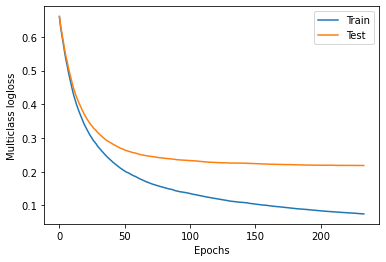

In [89]:
hist = model.evals_result()
plt.plot(hist['validation_0']['logloss'], label='Train')
plt.plot(hist['validation_1']['logloss'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()

In [90]:
print(classification_report(model.predict(X_test), y_test['AGN'], digits=4))

              precision    recall  f1-score   support

           0     0.9477    0.9126    0.9298     10358
           1     0.8276    0.8927    0.8589      4865

    accuracy                         0.9063     15223
   macro avg     0.8876    0.9027    0.8944     15223
weighted avg     0.9093    0.9063    0.9072     15223



In [91]:
i=2

filt = y_test['Source']==y_test.Source.unique()[i]
print(y_test.Source.unique()[i])
print(classification_report(model.predict(X_test[filt]), y_test['AGN'][filt], digits=4))

MIGHTEE
              precision    recall  f1-score   support

           0     0.8635    0.7735    0.8161       499
           1     0.5534    0.6965    0.6167       201

    accuracy                         0.7514       700
   macro avg     0.7084    0.7350    0.7164       700
weighted avg     0.7745    0.7514    0.7588       700



In [92]:
for i in range(4):

    filt = y_test['Classification']==i
    print(le.classes_[i])
    print("Accuracy=",accuracy_score(model.predict(X_test[filt]), y_test['AGN'][filt]))
    print("---------------------------------------------------")

jet-mode radio AGN/low-excitation radio galaxy
Accuracy= 0.8650963597430407
---------------------------------------------------
quasar-like radio AGN / high-excitation radio galaxy
Accuracy= 0.9002932551319648
---------------------------------------------------
radio-quiet AGN
Accuracy= 0.6865926558497011
---------------------------------------------------
star-forming galaxy
Accuracy= 0.9476691729323308
---------------------------------------------------


In [37]:
y_test.Classification.unique()

array([3, 0, 1, 2])

In [82]:
shap_values = shap.TreeExplainer(model, check_additivity=False).shap_values(X_train, check_additivity=False)

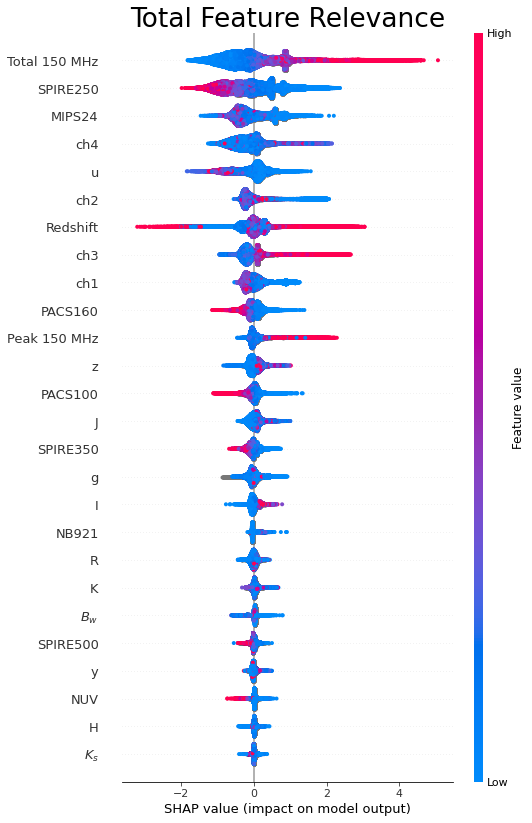

In [83]:
shap.summary_plot(shap_values, X_train.rename(columns=mapping), class_names=labels, max_display=999, show=False)
plt.title("Total Feature Relevance")
plt.tight_layout()

# Step 2: Subclasses

In [32]:
y_sub = y[y.Classification!=3]
X_sub = X[y.Classification!=3]
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, train_size=0.8, stratify=y_sub[['Source', 'Classification']])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test[['Source', 'Classification']])

In [26]:
import warnings

X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub['Classification'], train_size=0.8, stratify=y_sub[['Source', 'Classification']], random_state=42)

estimators = ['xgb_limitdepth']
#estimators = ['extra_tree']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    automl.fit(X_train, y_train, task="classification", metric='accuracy',
                                #X_val=X_val , y_val=y_val,
                                #ensemble=True,
                                estimator_list=estimators, 
                                time_budget=600, n_jobs=8,
                                eval_method='cv',
                                #log_file_name='general_extra_features3.log',
                                #starting_points=automl.best_config_per_estimator
              )

[flaml.automl: 02-08 16:00:19] {2390} INFO - task = classification
[flaml.automl: 02-08 16:00:19] {2392} INFO - Data split method: stratified
[flaml.automl: 02-08 16:00:19] {2396} INFO - Evaluation method: cv
[flaml.automl: 02-08 16:00:19] {2465} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 02-08 16:00:19] {2605} INFO - List of ML learners in AutoML Run: ['xgb_limitdepth']
[flaml.automl: 02-08 16:00:19] {2897} INFO - iteration 0, current learner xgb_limitdepth
[flaml.automl: 02-08 16:00:56] {3025} INFO - Estimated sufficient time budget=368116s. Estimated necessary time budget=368s.
[flaml.automl: 02-08 16:00:56] {3072} INFO -  at 37.0s,	estimator xgb_limitdepth's best error=0.0894,	best estimator xgb_limitdepth's best error=0.0894
[flaml.automl: 02-08 16:00:56] {2897} INFO - iteration 1, current learner xgb_limitdepth
[flaml.automl: 02-08 16:01:29] {3072} INFO -  at 70.2s,	estimator xgb_limitdepth's best error=0.0894,	best estimator xgb_limitdepth's best error=0.0894
[fla

In [27]:
automl.best_config_per_estimator['xgb_limitdepth']

{'n_estimators': 20,
 'max_depth': 7,
 'min_child_weight': 0.7694377042261122,
 'learning_rate': 1.0,
 'subsample': 1.0,
 'colsample_bylevel': 0.9088550158793876,
 'colsample_bytree': 0.7967145599266738,
 'reg_alpha': 0.058176484040363505,
 'reg_lambda': 4.081433281365178}

In [65]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=5,
                     #min_child_weight=0.7694377042261122,
                     learning_rate=0.3,
                      tree_method='hist',
                     #reg_alpha=0.058176484040363505,
                     #reg_lambda=4.081433281365178,
                     eval_metric=['merror', 'mlogloss'],
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

In [66]:
eval_set = [(X_train, y_train['Classification']), (X_val, y_val['Classification'])]

In [70]:
model.fit(X_train, y_train['Classification'], verbose=True, eval_set=eval_set, early_stopping_rounds=5)

[0]	validation_0-merror:0.10546	validation_0-mlogloss:0.80836	validation_1-merror:0.11509	validation_1-mlogloss:0.81208
[1]	validation_0-merror:0.10142	validation_0-mlogloss:0.63901	validation_1-merror:0.10213	validation_1-mlogloss:0.64529
[2]	validation_0-merror:0.09616	validation_0-mlogloss:0.52892	validation_1-merror:0.09756	validation_1-mlogloss:0.53696
[3]	validation_0-merror:0.09421	validation_0-mlogloss:0.45164	validation_1-merror:0.09451	validation_1-mlogloss:0.46224
[4]	validation_0-merror:0.09094	validation_0-mlogloss:0.39734	validation_1-merror:0.09451	validation_1-mlogloss:0.41045
[5]	validation_0-merror:0.08827	validation_0-mlogloss:0.35747	validation_1-merror:0.09146	validation_1-mlogloss:0.37181
[6]	validation_0-merror:0.08598	validation_0-mlogloss:0.32798	validation_1-merror:0.08918	validation_1-mlogloss:0.34437
[7]	validation_0-merror:0.08415	validation_0-mlogloss:0.30536	validation_1-merror:0.08841	validation_1-mlogloss:0.32237
[8]	validation_0-merror:0.08240	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['merror', 'mlogloss'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100000, n_jobs=8, nthread=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

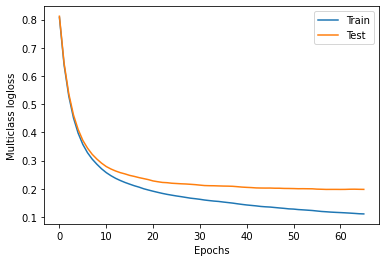

In [71]:
hist = model.evals_result()
plt.plot(hist['validation_0']['mlogloss'], label='Train')
plt.plot(hist['validation_1']['mlogloss'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()

In [72]:
print(classification_report(model.predict(X_test), y_test['Classification'], digits=4))

              precision    recall  f1-score   support

           0     0.9798    0.9421    0.9606      3904
           1     0.3191    0.6325    0.4242       166
           2     0.9193    0.9092    0.9142      1178

    accuracy                         0.9249      5248
   macro avg     0.7394    0.8279    0.7663      5248
weighted avg     0.9453    0.9249    0.9332      5248

